In [1]:
from fractal_printer import fractal_sdfs as fs
import quaternion as qu
import matplotlib.pyplot as plt
import numpy as np
from sdf.sdf.d3 import sphere, torus, slab
from importlib import reload
from sdf.sdf import d3


In [ ]:

def mag2(z):
    return np.abs(z)**2

print(mag2(qu.from_float_array([1,1,1,1])))

@d3.sdf3
def quaternion_julia_sdf(c, n = 2, iterations = 50, bailout_level = 10000**2, offset=0):

    def distance(p):
        # Convert starting points to quaterinons
        z = qu.from_float_array(
            np.concatenate(
                (p,np.zeros((p.shape[:-1]+(1,)))),
                axis=1
            )
        )

        # Define helper arrays
        z2 = mag2(z)                                    # Current mag^2 of tracked point
        zp2 =         np.ones(p.shape[:-1],dtype=float) # Current mag^2 of derivative
        bailout =     np.zeros(p.shape[:-1],dtype=bool) # Mask of points that have crossed the bailout threshold
        new_bailout = np.zeros(p.shape[:-1],dtype=bool) # Mask of points that have crossed the bailout threshold this iteration

        for _ in range(iterations):
            # Update points
            zp2[~bailout] = n*n*z2[~bailout]*zp2[~bailout]
            z[~bailout] = z[~bailout]**n + c
            z2[~bailout] = mag2(z[~bailout])

            # Update mask
            new_bailout = (z2 > bailout_level) & ~bailout
            bailout = bailout | new_bailout

        dist = np.sqrt(z2/zp2)*0.5*np.log(z2)
        return dist - offset

    return distance

AttributeError: 'numpy.float64' object has no attribute '__type__'

In [10]:
# Make construct an sdf estimator for a 3D julia set
reload(fs)

julia_sdf = fs.quaternion_julia_sdf(qu.quaternion(0.4,0.2,0.5,0), iterations=60, offset=0.005)

# Test it
p = np.array([[0,10,0],[10,0,0]])
print(julia_sdf(p))

# Use the SDF to make a 2d rendering of the julia set
points = 500
radius = 1.2
x = np.linspace(-radius,radius,points)
y = np.linspace(-radius,radius,points)

X,Y = np.meshgrid(x, y, indexing="xy")

p = np.vstack((X.flatten(), Y.flatten(), np.zeros_like(X).flatten())).T
print(p[134])
d = julia_sdf(p)

# Plot it!
D = d.reshape((points,points))

im = plt.imshow(D)
plt.contour(D,levels=[0],colors="w")
plt.colorbar(im)

TypeError: Cannot cast data from quaternion to float64.

In [ ]:
# Export a 3d rendering
radius = 1.2
julia_sdf.save("test_julia_1.stl",bounds = ([-radius]*3,[radius]*3), samples=2**24)

min -1.2, -1.2, -1.2
max 1.2, 1.2, 1.2
step 0.009375, 0.009375, 0.009375
18191447 samples in 512 batches with 8 workers
  100% (512 of 512) [##############################] 0:00:15 0:00:00    
201 skipped, 22 empty, 289 nonempty
2737018 triangles in 15.2351 seconds


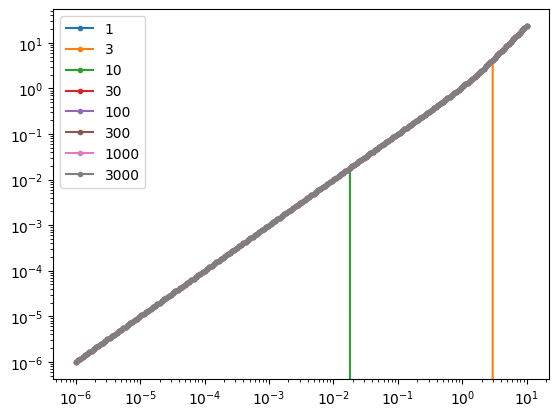

In [ ]:
# Test convergence with iteration count

fig, ax = plt.subplots(1,1)

ax.set_xscale("log")
ax.set_yscale("log")
y = np.geomspace(1e-6,1e1,200)
points = np.vstack((np.zeros_like(y),y,np.zeros_like(y))).T

for iterations in [1,3,10,30,100,300,1000,3000]:
    line_julia = df.generalized_mandelbrot(cx=-2, iterations=iterations, offset=0)

    distance = line_julia(points)

    ax.plot(y,distance,".-",label=iterations)

ax.legend()



min -1.2, -1.2, -1.2
max 1.2, 1.2, 1.2
step 0.009375, 0.009375, 0.009375
18191447 samples in 512 batches with 8 workers
  100% (512 of 512) [##############################] 0:00:21 0:00:00    
194 skipped, 20 empty, 298 nonempty
2098648 triangles in 21.033 seconds
 
*** Profile stats marshalled to file '/tmp/tmpp4qo3hde'.
Embedding SnakeViz in this document...
<function display at 0x7c80911a4680>


In [ ]:
# Export a sliced 3D rendering
sectioned_julia = julia_sdf & slab(z0 = 0)
sectioned_julia.save("sectioned_julia.stl",bounds = ([-radius]*3,[radius]*3), samples=2**24)

min -1.2, -1.2, -1.2
max 1.2, 1.2, 1.2
step 0.009375, 0.009375, 0.009375
18191447 samples in 512 batches with 8 workers
  100% (512 of 512) [##############################] 0:00:15 0:00:00    
311 skipped, 52 empty, 149 nonempty
1064428 triangles in 15.0831 seconds
